### **Linear Regression Class**

In [188]:
import numpy as np

class LinearRegression:
    def __init__(self, add_bias=True, regularization=None, alpha=0.0, learning_rate=0.01, max_iter=1000, use_gradient_descent=False):

        self.add_bias = add_bias
        self.regularization = regularization
        self.alpha = alpha  # Regularization strength
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.use_gradient_descent = use_gradient_descent
        self.w_history = []  # To store weight history for visualization

    def fit(self, x, y):

        if x.ndim == 1:
            x = x[:, None]  # Ensure x is 2D

        N, D = x.shape
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])  # Add bias term

        if self.regularization == 'L2':  # Ridge (L2 regularization)
            if self.use_gradient_descent:
                # Initialize weights
                self.w = np.zeros(x.shape[1])
                for i in range(self.max_iter):
                    y_pred = x @ self.w
                    # Compute the gradient
                    grad = (x.T @ (y_pred - y)) / N
                    # Add L2 regularization to the gradient (not for the bias term)
                    grad[1:] += self.alpha * self.w[1:]
                    # Update weights using gradient descent
                    self.w -= self.learning_rate * grad
                    # Store the weight history
                    self.w_history.append(self.w.copy())
            else:
                # Closed-form solution for Ridge regression
                I = np.eye(x.shape[1])
                if self.add_bias:
                    I[-1, -1] = 0  # Do not regularize the bias term
                self.w = np.linalg.pinv(x.T @ x + self.alpha * I) @ x.T @ y

        elif self.regularization == 'L1':  # Lasso (L1 regularization)
            # Initialize weights
            self.w = np.zeros(x.shape[1])
            for i in range(self.max_iter):
                y_pred = x @ self.w
                # Compute the subgradient for L1 regularization
                grad = (x.T @ (y_pred - y)) / N
                # Apply L1 regularization to the subgradient (not for the bias term)
                grad[1:] += self.alpha * np.sign(self.w[1:])
                # Update weights using gradient descent
                self.w[1:] -= self.learning_rate * (grad[1:] + self.alpha * np.sign(self.w[1:]))  # Update only for features
                self.w[0] -= self.learning_rate * grad[0]  # Bias term (not regularized)
                # Store the weight history
                self.w_history.append(self.w.copy())

        else:  # No regularization (standard pseudo-inverse)
            xtx_inv = np.linalg.pinv(np.matmul(x.T,x))
            xtx_inv_xt = np.matmul(xtx_inv,x.T)
            self.w = np.matmul(xtx_inv_xt,y)

        return self

    def predict(self, x):

        if x.ndim == 1:
            x = x[:, None]  # Ensure x is 2D
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(N)])  # Add bias term

        # Compute the predicted y values
        return x @ self.w


### **1.1: Data Generation**

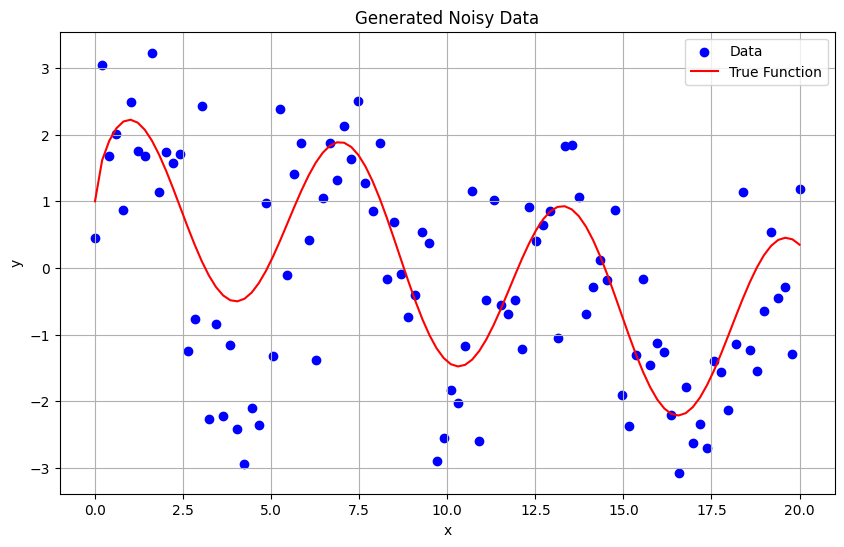

In [193]:

import matplotlib.pyplot as plt

def true_f(x):
    return np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x)

def f(x, eps):
    y = np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x) + eps
    return y

def generate_data(size):
    x = np.linspace(0, 20, size)
    eps = np.random.normal(0, 1, 100)
    y = f(x, eps)
    return x, y

x,y_noisy = generate_data(100)
y_true = true_f(x)

# Plot the data points
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, label='Data', color='blue')
plt.plot(x, y_true, label='True Function', color='red')
plt.title('Generated Noisy Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


### **1.2: Non-Lienar Basis Functions**

In [194]:
def gaussian_basis(x, mu, sigma=1):
    return np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

def create_bases(x, D):
    if D == 0:
        return x.reshape(-1, 1)  # Ensure x is reshaped to 2D
    mu_values = np.linspace(np.min(x), np.max(x), D)
    bases_matrix = np.array([gaussian_basis(x, mu) for mu in mu_values])
    return bases_matrix.T  # Shape: (n_samples, D)


bases = create_bases(x,0)
print(bases.shape)


(100, 1)


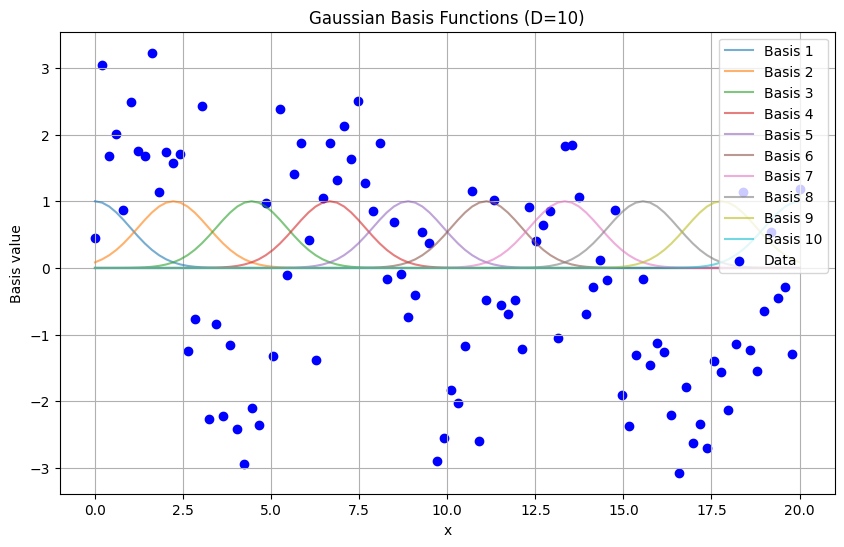

In [195]:

D = 10
bases = create_bases(x, D)

# Plot
plt.figure(figsize=(10, 6))
for i in range(D):
    plt.plot(x, bases[:, i], label=f'Basis {i+1}', alpha=0.6)
plt.scatter(x, y_noisy, label='Data', color='blue')
plt.title(f'Gaussian Basis Functions (D={D})')
plt.xlabel('x')
plt.ylabel('Basis value')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

### **1.3: Model Fitting**

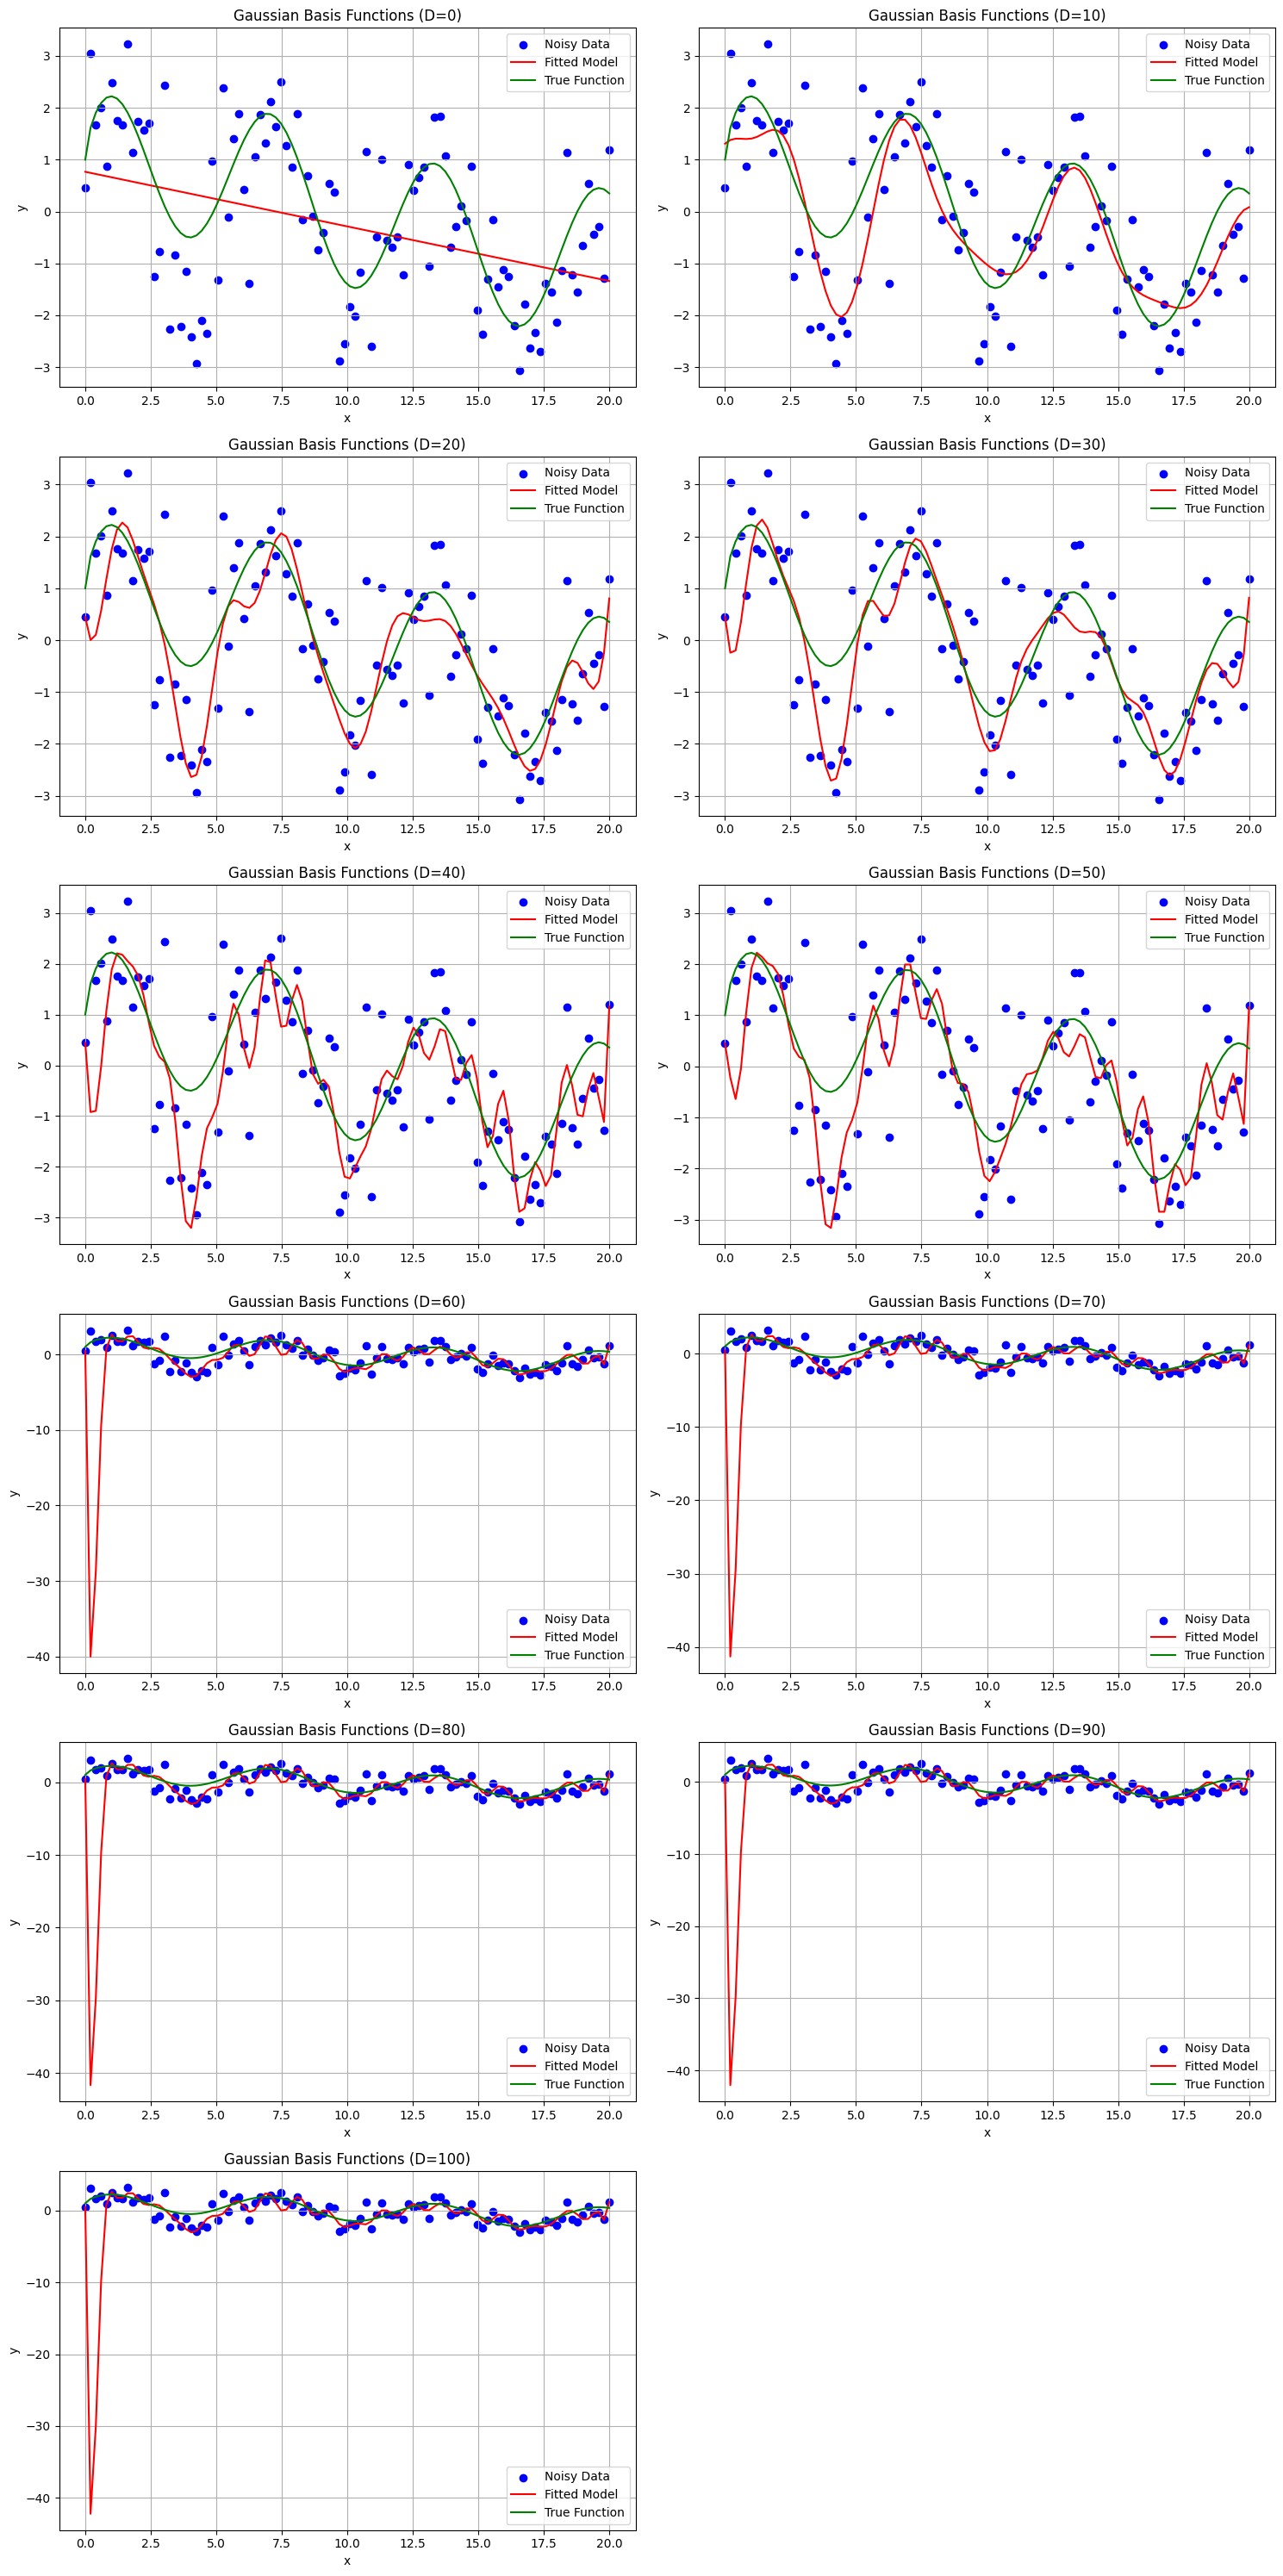

In [196]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=10)

D_values = np.arange(0, 101, 10)

plt.figure(figsize=(15, 30))
for i, D in enumerate(D_values):
    # Transform the original uniform data using Gaussian basis functions
    x_train_transformed = create_bases(x_train, D)
    x_transformed = create_bases(x, D)
    # Fit linear regression to the transformed data
    model = LinearRegression()
    model.fit(x_train_transformed, y_train)  # Fit on transformed training data

    # Predict y values for the same x values
    y_pred = model.predict(x_transformed) #predict on whole dataset

    # Plot the results
    plt.subplot(6, 2, i + 1)
    plt.scatter(x, y_noisy, label='Noisy Data', color='blue')
    plt.plot(x, y_pred, label='Fitted Model', color='red')
    plt.plot(x, true_f(x), label='True Function', color='green')
    plt.title(f'Gaussian Basis Functions (D={D})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### **1.4:Model Selection**

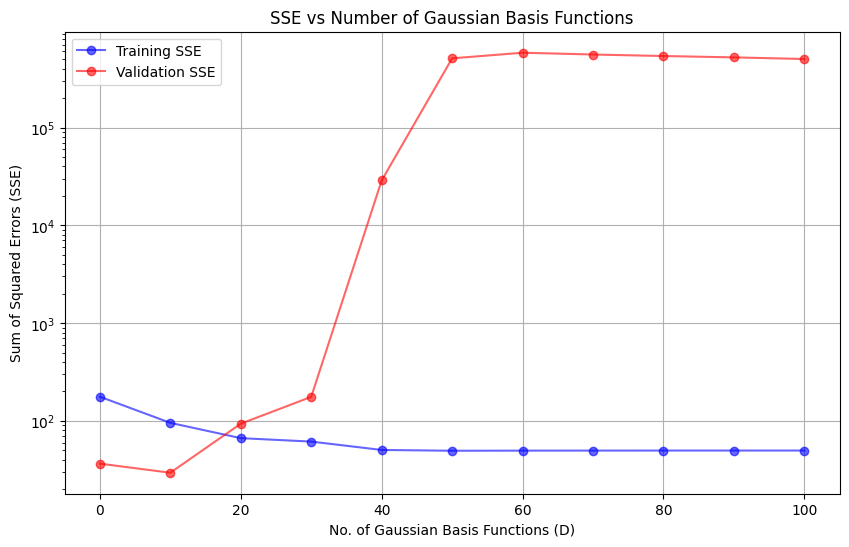

[176.83618594731593, 95.5671334815409, 66.66498028496501, 61.47937409002162, 50.487246994460534, 49.552215835892156, 49.681353670512095, 49.746661772580076, 49.77940869920184, 49.79396271027399, 49.80491888412012]
[36.568241042331735, 29.536325283734808, 93.6385718182575, 176.26797628819526, 28797.298767027147, 510086.02492977085, 582206.8236423455, 558229.3276948552, 538707.3990548268, 521660.479242, 502140.9727287752]


In [ ]:
#splitting into train,val
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.2, random_state=20)

#to store sse
sse_train = []
sse_val = []
for D in (D_values):
    x_train_transformed = create_bases(x_train, D)
    x_val_transformed = create_bases(x_val, D)

    model.fit(x_train_transformed, y_train)

    # Predict y values on  training, validation sets
    y_train_pred = model.predict(x_train_transformed)
    y_val_pred = model.predict(x_val_transformed)

    # Compute SSE
    sse_train.append(np.sum((y_train_pred - y_train) ** 2))
    sse_val.append(np.sum((y_val_pred - y_val) ** 2))

plt.figure(figsize=(10, 6))
plt.plot(D_values, sse_train, label='Training SSE', marker='o', color='blue',alpha = 0.6)
plt.plot(D_values, sse_val, label='Validation SSE', marker='o', color='red',alpha = 0.6)
#plt.axvline(x=optimal_D, color='green', linestyle='--', label=f'Optimal D = {optimal_D}')
plt.title('SSE vs Number of Gaussian Basis Functions')
plt.xlabel('No. of Gaussian Basis Functions (D)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

print(sse_train)
print(sse_val)

## **TASK 2**

Plotting Multiple Fits


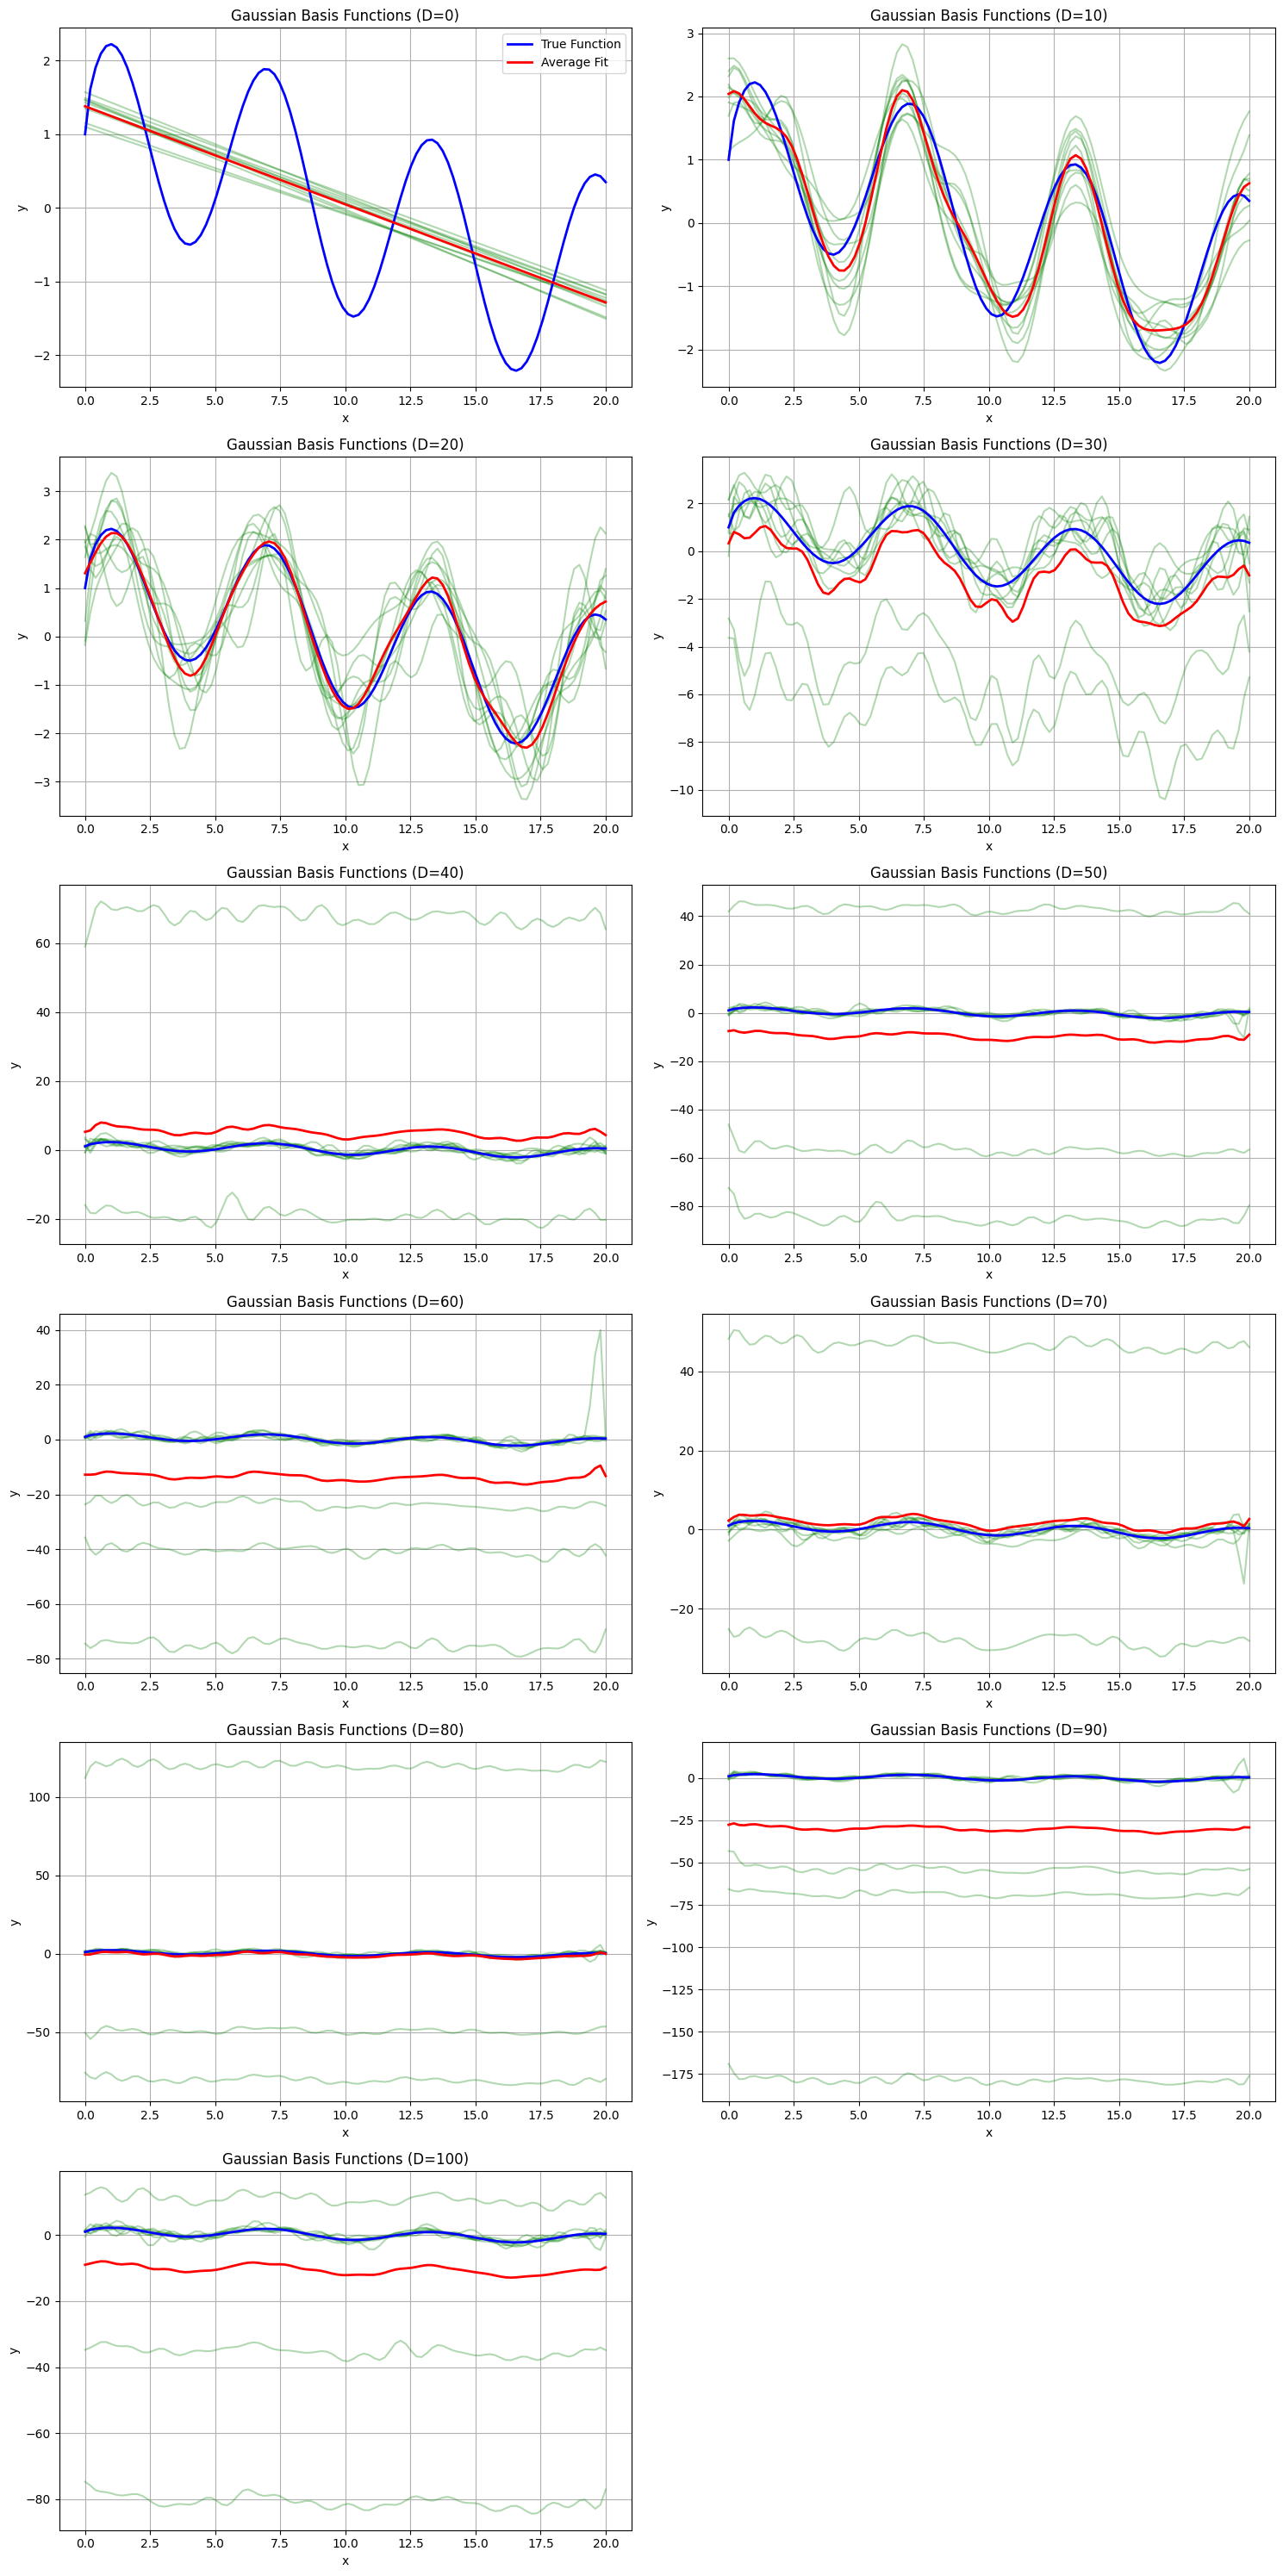

In [ ]:
D_values = np.arange(0, 101, 10)
n_subplots = len(D_values)

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
axes = axes.flatten()

for idx, D in enumerate(D_values):
    all_predictions = []

    # Perform 10 iterations for each D
    for iteration in range(10):
        x, y_noisy = generate_data(100)

        x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=iteration)

        x_train_transformed = create_bases(x_train, D)
        x_transformed_full = create_bases(x, D)

        model = LinearRegression()
        model.fit(x_train_transformed, y_train)

        y_pred = model.predict(x_transformed_full)  # Predict on full dataset

        # Store predictions for averaging
        all_predictions.append(y_pred)

    # Plot all 10 model fits in green on the corresponding subplot
    for y_pred in all_predictions:
        axes[idx].plot(x, y_pred, color='green', alpha=0.3)

    # Calculate the average of the 10 fitted models
    ave_pred = np.mean(all_predictions, axis=0)

    # Plot the true underlying function in blue
    axes[idx].plot(x, true_f(x), label='True Function', color='blue', linewidth=2)

    # Plot the average of the 10 fitted models in red
    axes[idx].plot(x, ave_pred, label='Average Fit', color='red', linewidth=2)

    # Set titles and labels
    axes[idx].set_title(f'Gaussian Basis Functions (D={D})')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('y')

    axes[idx].grid(True)

    # Show legends only in the first plot to avoid clutter
    if idx == 0:
        axes[idx].legend()

# Remove any empty subplots if there are any
if len(D_values) < len(axes):
    for i in range(len(D_values), len(axes)):
        fig.delaxes(axes[i])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



###2.3: Plotting Train/Test Errors


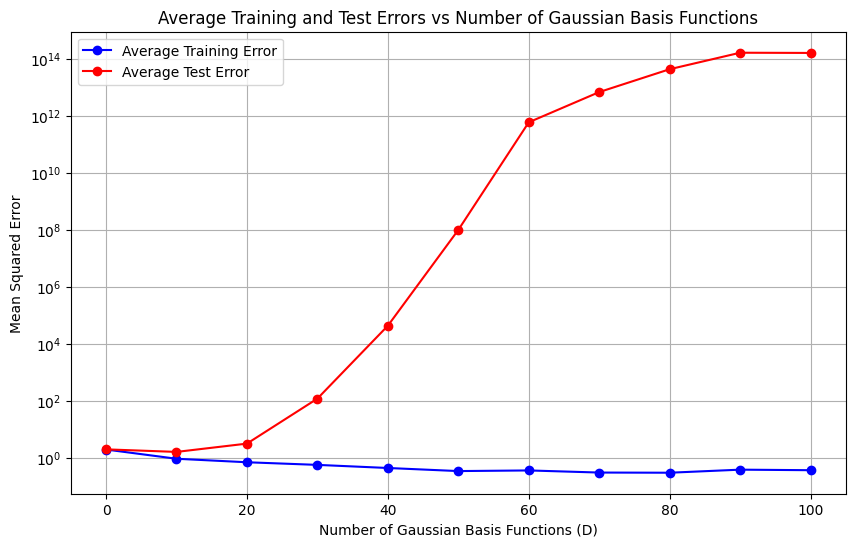

[2.00792018e+00 1.63370076e+00 3.19203070e+00 1.20569728e+02
 4.32536015e+04 9.86561187e+07 5.83113546e+11 6.68275145e+12
 4.22692496e+13 1.59911914e+14 1.57132852e+14]


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming D_values is defined, and functions like generate_data(), true_f(), and create_bases() are implemented
D_values = np.arange(0, 101, 10)  # Number of Gaussian basis functions (D)

# To store the errors for each D across 10 iterations
train_errors = np.zeros(len(D_values))
test_errors = np.zeros(len(D_values))

# Run 10 iterations
for i in range(10):
    # Generate new data
    x, y_noisy = generate_data(100)

    # Split the data into training and test sets (80% training, 20% test)
    x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=i)

    # To store errors for the current iteration
    iteration_train_errors = []
    iteration_test_errors = []

    # Loop over each D value
    for idx, D in enumerate(D_values):
        # Transform the data using Gaussian basis functions
        x_train_transformed = create_bases(x_train, D)
        x_test_transformed = create_bases(x_test, D)

        # Fit the model on the training data
        model = LinearRegression()
        model.fit(x_train_transformed, y_train)

        # Predict on the training and test sets
        y_train_pred = model.predict(x_train_transformed)
        y_test_pred = model.predict(x_test_transformed)

        # Compute the training and test errors (Mean Squared Error)
        train_error = mean_squared_error(y_train, y_train_pred)
        test_error = mean_squared_error(y_test, y_test_pred)

        # Store errors for this D value
        iteration_train_errors.append(train_error)
        iteration_test_errors.append(test_error)

    # Accumulate the errors for each D value
    train_errors += np.array(iteration_train_errors)
    test_errors += np.array(iteration_test_errors)

# Compute the average training and test errors over 10 iterations
average_train_errors = train_errors / 10
average_test_errors = test_errors / 10

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(D_values, average_train_errors, label='Average Training Error', color='blue', marker='o')
plt.plot(D_values, average_test_errors, label='Average Test Error', color='red', marker='o')

# Labels and title
plt.title('Average Training and Test Errors vs Number of Gaussian Basis Functions')
plt.xlabel('Number of Gaussian Basis Functions (D)')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

print(average_test_errors)

### TASK 3: Adding Regularization

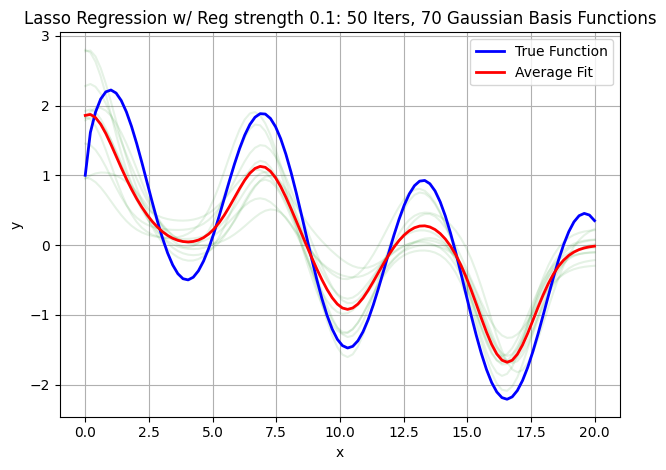

In [ ]:
from sklearn.preprocessing import StandardScaler

n_iterations = 10
n_samples = 100
D = 70
alpha_L1 = 0.1


all_predictions = []


x = np.linspace(0, 20, n_samples)
true_y = true_f(x)


for iteration in range(n_iterations):

    x_data, y_data = generate_data(n_samples)


    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=iteration)


    x_train_transformed = create_bases(x_train, D)
    x_test_transformed = create_bases(x_test, D)
    x_transformed_full = create_bases(x_data, D)

    # Normalize  features
    scaler = StandardScaler()
    x_train_transformed = scaler.fit_transform(x_train_transformed)
    x_test_transformed = scaler.transform(x_test_transformed)
    x_transformed_full = scaler.transform(x_transformed_full)

    # Train the model on the training data (Ridge with subgradient)
    model = LinearRegression(regularization='L1', alpha = alpha_L1)
    model.fit(x_train_transformed, y_train)

    # Predict the outputs for the full x (for plotting)
    y_pred = model.predict(x_transformed_full)

    # Store predictions for averaging later
    all_predictions.append(y_pred)

    # Plot the current model fit (in light green)
    plt.plot(x_data, y_pred, color='green', alpha=0.1)

# Calculate the average of the 50 model fits
average_prediction = np.mean(all_predictions, axis=0)

# Plot the true underlying function (in blue)
plt.plot(x, true_y, label='True Function', color='blue', linewidth=2)

# Plot the average of the 50 model fits (in red)
plt.plot(x, average_prediction, label='Average Fit', color='red', linewidth=2)

# Set titles and labels
plt.title(f'Lasso Regression w/ Reg strength {alpha_L1}: 50 Iters, 70 Gaussian Basis Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3.2: Cross Fold Validation

In [ ]:
# Define a function for manual 10-fold cross-validation for Lasso (L1) or Ridge (L2)
def kfold_cross_val(x_train, y_train, lambdas, regularization=None, k=10, max_iter=10000, learning_rate=0.01):


    # Number of samples in the training set
    n_train_samples = len(y_train)

    # Shuffle the training data for cross-validation
    shuffled_indices = np.random.permutation(n_train_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    # Split training data into n_folds subsets for K-fold cross-validation
    fold_size = n_train_samples // k
    folds_x = [x_train_shuffled[i*fold_size:(i+1)*fold_size] for i in range(k)]
    folds_y = [y_train_shuffled[i*fold_size:(i+1)*fold_size] for i in range(k)]

    mse_train = []
    mse_val = []

    # Iterate over each lambda (regularization strength)
    for lmbda in lambdas:
        fold_mse_train = []
        fold_mse_val = []

        # For each fold, train on 9 folds and validate on the 10th
        for i in range(k):
            # Prepare training data (use all but the i-th fold)
            x_train_fold = np.vstack([folds_x[j] for j in range(k) if j != i])
            y_train_fold = np.hstack([folds_y[j] for j in range(k) if j != i])

            # Prepare validation data (use the i-th fold)
            x_val_fold = folds_x[i]
            y_val_fold = folds_y[i]

            # Train the model (L1 or L2 regularization)
            model = LinearRegression(regularization=regularization, alpha=lmbda, learning_rate=learning_rate, max_iter=max_iter)
            model.fit(x_train_fold, y_train_fold)

            # Compute predictions for training and validation sets
            y_pred_train_fold = model.predict(x_train_fold)
            y_pred_val_fold = model.predict(x_val_fold)

            # Calculate MSE for training and validation sets
            mse_train_fold = np.mean((y_train_fold - y_pred_train_fold) ** 2)
            mse_val_fold = np.mean((y_val_fold - y_pred_val_fold) ** 2)

            # Store MSE for this fold
            fold_mse_train.append(mse_train_fold)
            fold_mse_val.append(mse_val_fold)

        # Compute the average MSE across all folds for this lambda
        mse_train.append(np.mean(fold_mse_train))
        mse_val.append(np.mean(fold_mse_val))

    return mse_train, mse_val

### **3.3: Plotting Train/Test Errors**

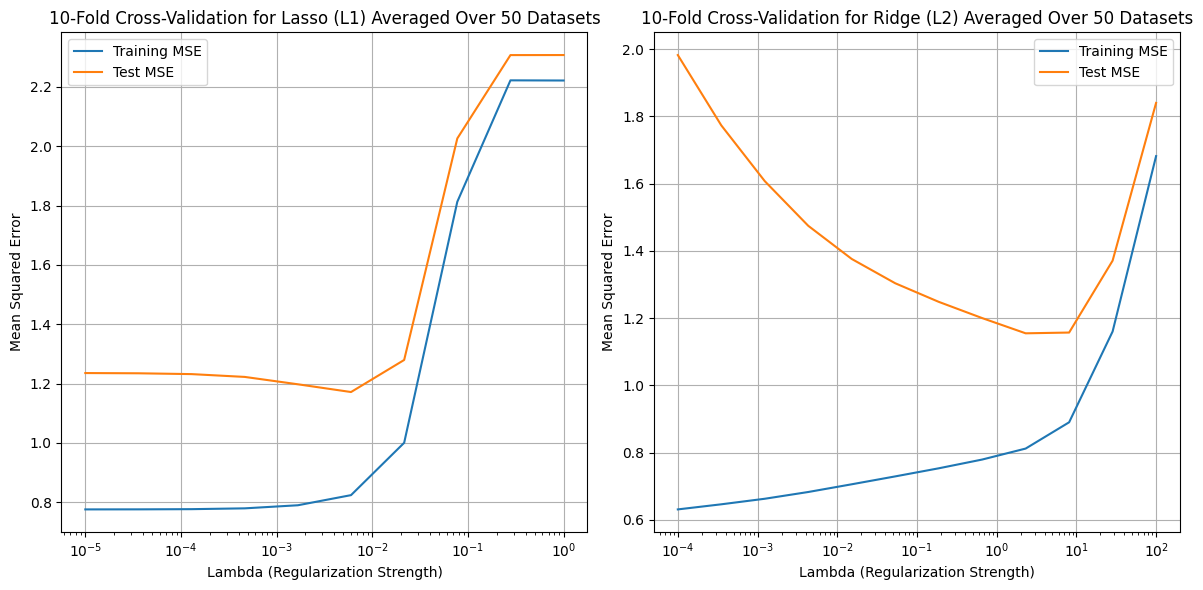

In [ ]:
#  parameters
num_datasets = 50
n_samples = 100
D = 70
lambdas_L1 = np.logspace(-5, 0, 10)
lambdas_L2 = np.logspace(-4, 2, 12)


mse_train_l1_accum = np.zeros(len(lambdas_L1))
mse_val_l1_accum = np.zeros(len(lambdas_L1))

mse_train_l2_accum = np.zeros(len(lambdas_L2))
mse_val_l2_accum = np.zeros(len(lambdas_L2))


for dataset_iter in range(num_datasets):
    x, y_noisy = generate_data(n_samples)
    x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=10)


    x_train_transformed = create_bases(x_train, D)
    x_test_transformed = create_bases(x_test, D)

    mse_train_l1, mse_val_l1 = kfold_cross_val(x_train_transformed, y_train, lambdas_L1, regularization='L1', k=10)
    mse_train_l2, mse_val_l2 = kfold_cross_val(x_train_transformed, y_train, lambdas_L2, regularization='L2', k=10)

    mse_train_l1_accum += np.array(mse_train_l1)
    mse_val_l1_accum += np.array(mse_val_l1)

    mse_train_l2_accum += np.array(mse_train_l2)
    mse_val_l2_accum += np.array(mse_val_l2)

#average
mse_train_l1_avg = mse_train_l1_accum / num_datasets
mse_val_l1_avg = mse_val_l1_accum / num_datasets

mse_train_l2_avg = mse_train_l2_accum / num_datasets
mse_val_l2_avg = mse_val_l2_accum / num_datasets


plt.figure(figsize=(12, 6))

# Plot for Lasso (L1)
plt.subplot(1, 2, 1)
plt.plot(lambdas_L1, mse_train_l1_avg, label='Training MSE')
plt.plot(lambdas_L1, mse_val_l1_avg, label='Test MSE')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.title(f'10-Fold Cross-Validation for Lasso (L1) Averaged Over {num_datasets} Datasets')
plt.legend()
plt.grid(True)

# Plot for Ridge (L2)
plt.subplot(1, 2, 2)
plt.plot(lambdas_L2, mse_train_l2_avg, label='Training MSE')
plt.plot(lambdas_L2, mse_val_l2_avg, label='Test MSE')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.title(f'10-Fold Cross-Validation for Ridge (L2) Averaged Over {num_datasets} Datasets')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [234]:
print(mse_val_l1_avg)
print(lambdas_L1)

[1.2353684  1.23458125 1.23178898 1.22234032 1.19748606 1.17137776
 1.27951056 2.02639494 2.30741727 2.30756841]
[1.00000000e-05 3.59381366e-05 1.29154967e-04 4.64158883e-04
 1.66810054e-03 5.99484250e-03 2.15443469e-02 7.74263683e-02
 2.78255940e-01 1.00000000e+00]


# **3.4: Plotting Bias-Variance Decomposition**

In [ ]:
def calculate_bias_variance_decomposition(n_samples, lambdas, regularization='L1', D=70, n_datasets=50, noise_variance=1, test_size=0.2):
    bias_squared = np.zeros(len(lambdas))
    variance = np.zeros(len(lambdas))
    test_error = np.zeros(len(lambdas))

    # Generate 50 datasets and perform regularization
    all_predictions = {lmbda: [] for lmbda in lambdas}

    for _ in range(n_datasets):
        # Generate a new dataset (with noise)
        x, y_noisy = generate_data(n_samples)

        # Split the data into train and test sets
        x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=test_size, random_state=42)

        # Transform the original training and test data using Gaussian basis functions
        x_train_transformed = create_bases(x_train, D)
        x_test_transformed = create_bases(x_test, D)

        # Loop over each lambda (regularization strength)
        for i, lmbda in enumerate(lambdas):
            # Train the model (L1 or L2 regularization)
            model = LinearRegression(regularization=regularization, alpha=lmbda)
            model.fit(x_train_transformed, y_train)

            # Predict on the training set for bias-variance calculation
            y_pred_train = model.predict(x_train_transformed)
            all_predictions[lmbda].append(y_pred_train)

            # Predict on the test set for test error
            y_pred_test = model.predict(x_test_transformed)
            test_error[i] += np.mean((y_test - y_pred_test) ** 2)  # Accumulate test errors

    # Now calculate bias, variance, and average test error for each lambda
    for i, lmbda in enumerate(lambdas):
        predictions = np.array(all_predictions[lmbda])  # Shape (n_datasets, n_samples)

        # Calculate the mean of the predictions (average model)
        mean_pred = np.mean(predictions, axis=0)

        # Bias squared: (True Function - Mean Prediction)²
        bias_squared[i] = np.mean((mean_pred - y_train) ** 2)

        # Variance: Mean of (Each Model Prediction - Mean Prediction)²
        variance[i] = np.mean(np.var(predictions, axis=0))

        # Average the test errors across the datasets
        test_error[i] /= n_datasets  # Normalize by number of datasets

    # Return the calculated values for bias, variance, and test error
    return {
        'bias_squared': bias_squared,
        'variance': variance,
        'test_error': test_error
    }

In [ ]:
def plot_bias_variance(results, lambdas, regularization):
    plt.figure(figsize=(10, 6))

    plt.plot(lambdas, results['bias_squared'], label='Bias²')
    plt.plot(lambdas, results['variance'], label='Variance')
    plt.plot(lambdas, np.array(results['bias_squared']) + np.array(results['variance']), label='Bias² + Variance')
    #plt.plot(lambdas, np.array(results['bias_squared']) + np.array(results['variance']) + 1, label='Bias² + Variance + Noise')  # Assuming noise_variance = 1
    plt.plot(lambdas, results['test_error'], label='Test Error', linestyle='--')

    plt.xscale('log')
    plt.xlabel('Lambda (Regularization Strength)')
    plt.ylabel('Error')
    plt.title(f'Bias-Variance Decomposition for {regularization}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

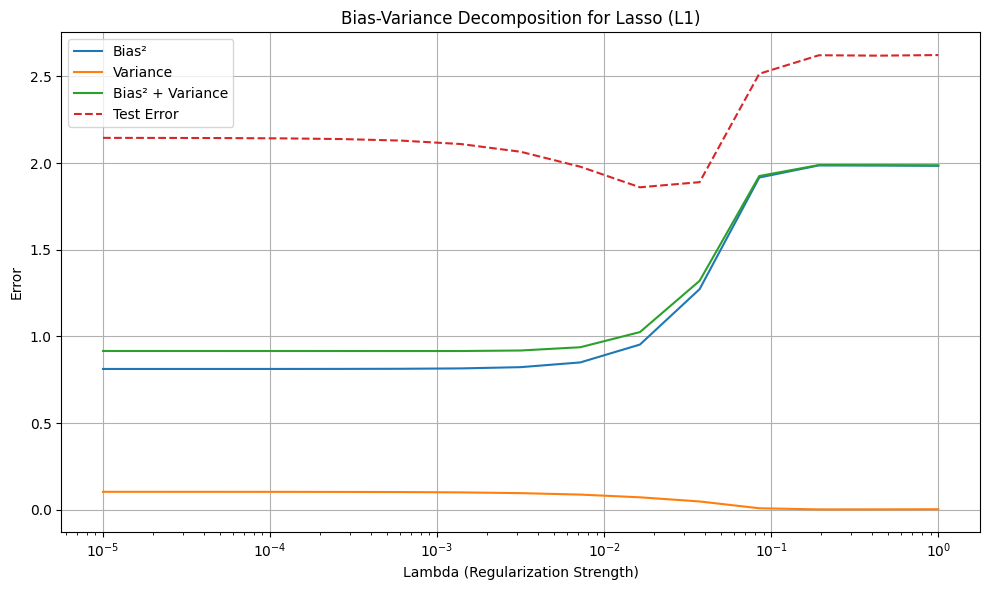

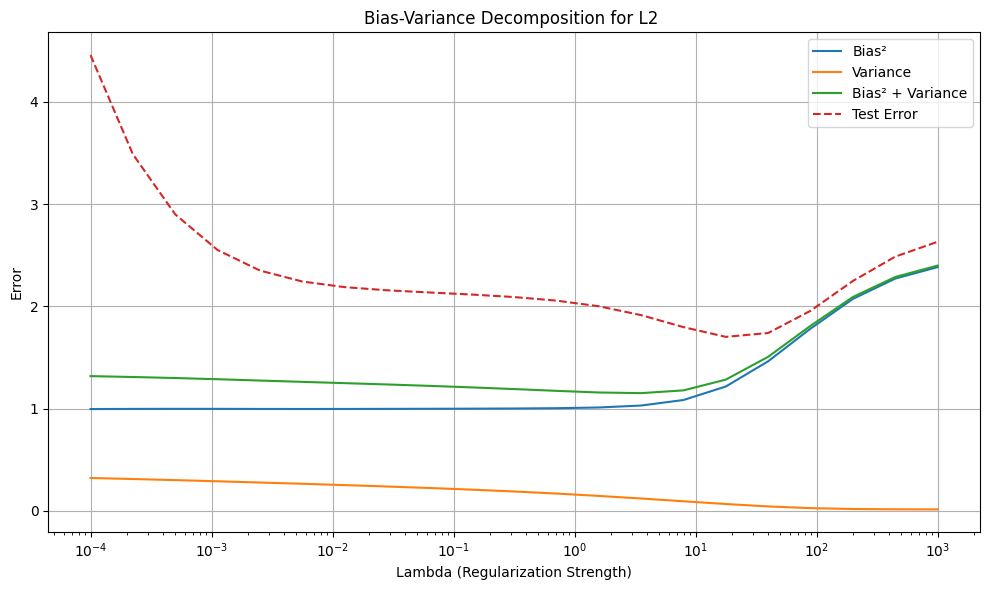

In [ ]:
n_samples = 100
lambdas_1 = np.logspace(-5, 0, 15)
lambdas_2 = np.logspace(-4, 3, 21)
D = 70  # Number of Gaussian basis functions
n_datasets = 50

# Calculate bias-variance decomposition for Lasso (L1)
results_l1 = calculate_bias_variance_decomposition(n_samples, lambdas_1, regularization='L1', D=D, n_datasets=n_datasets)

# Calculate bias-variance decomposition for Ridge (L2)
results_l2 = calculate_bias_variance_decomposition(n_samples, lambdas_2, regularization='L2', D=D, n_datasets=n_datasets)

# Plot Bias-Variance for Lasso (L1)
plot_bias_variance(results_l1, lambdas_1, regularization='Lasso (L1)')

# Plot Bias-Variance for Ridge (L2)
plot_bias_variance(results_l2, lambdas_2, regularization='L2 ')

### **TASK 4**

# 4.1: Generating **Data**

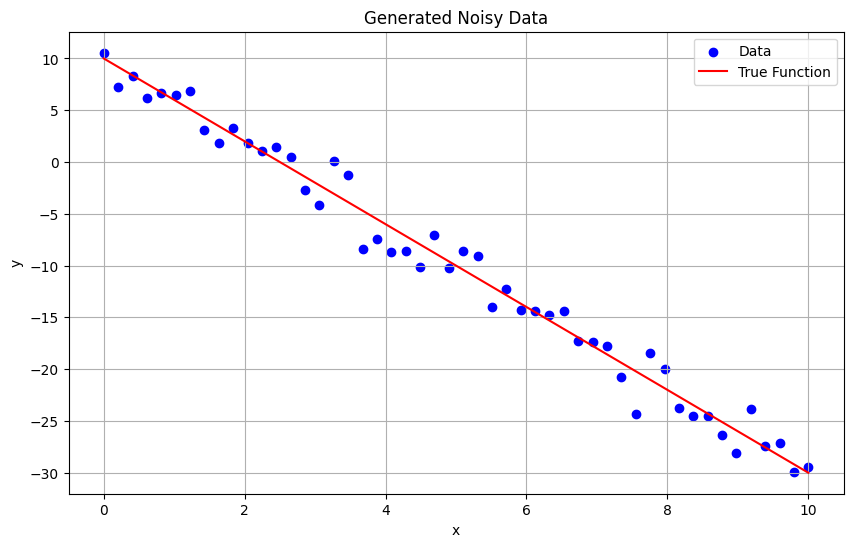

In [230]:
def true_f2(x):
    return -4*x +10

def f2(x, eps):
    y = -4*x +10 + 2*eps
    return y

def generate_data2(size):
    x = np.linspace(0, 10, size)
    eps = np.random.normal(0, 1, size)
    y = f2(x, eps)
    return x, y

x2,y2_noisy = generate_data2(50)
y2_true = true_f2(x2)

# Plot the data points
plt.figure(figsize=(10, 6))
plt.scatter(x2, y2_noisy, label='Data', color='blue')
plt.plot(x2, y2_true, label='True Function', color='red')
plt.title('Generated Noisy Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


4.3: Plotting Contours

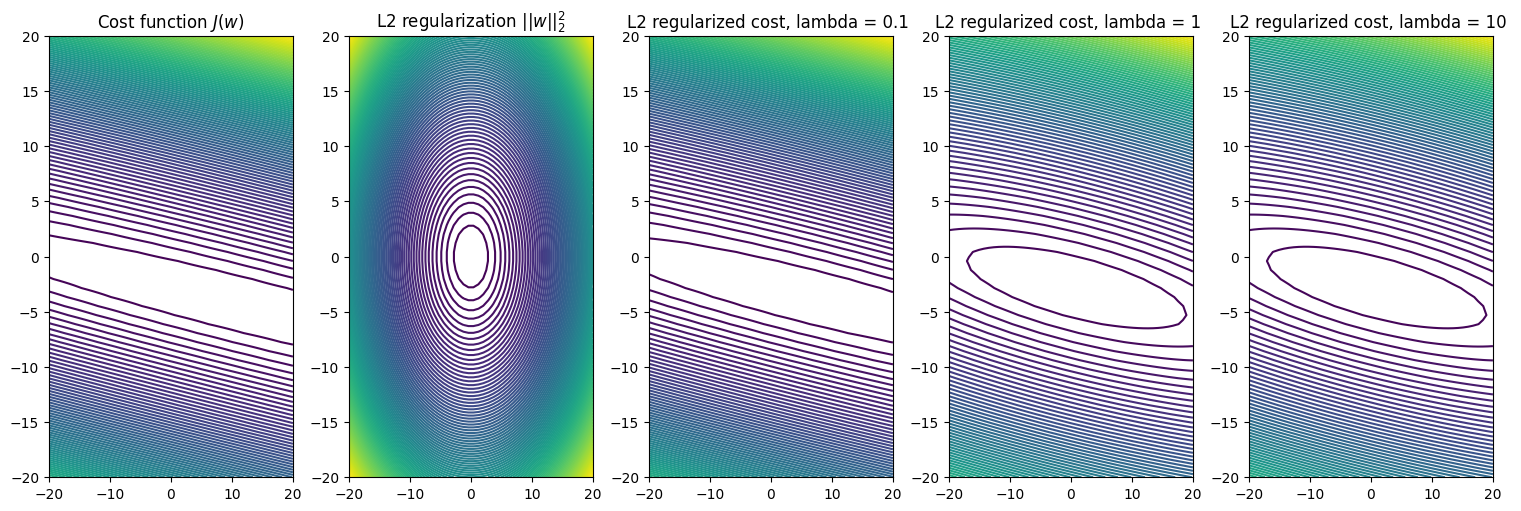

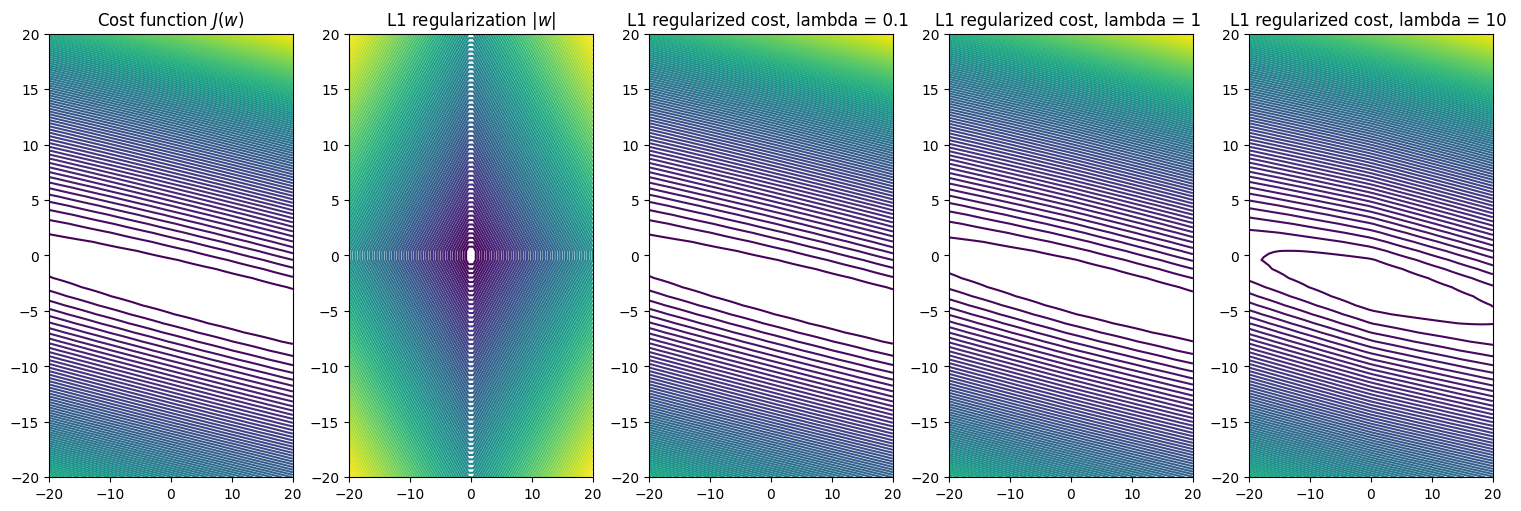

In [ ]:
import itertools

def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f([xg[i, j], yg[i, j]])
    ax.contour(xg, yg, zg, 100)
    return ax

# Generate synthetic data
N = 20
x = np.random.rand(N) * 10
y2 = -4*x + 10 + 2*np.random.randn(N)

# Define cost function and penalties
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y2)**2)
l2_penalty = lambda w: np.dot(w, w) / 2
l1_penalty = lambda w: np.sum(np.abs(w))
cost_plus_l2_01 = lambda w: cost(w) + 0.1*l2_penalty(w)
cost_plus_l1_01 = lambda w: cost(w) + 0.1*l1_penalty(w)
cost_plus_l2_1 = lambda w: cost(w) + l2_penalty(w)
cost_plus_l1_1 = lambda w: cost(w) + l1_penalty(w)
cost_plus_l2_10 = lambda w: cost(w) + 5*l2_penalty(w)
cost_plus_l1_10 = lambda w: cost(w) + 5*l1_penalty(w)

# Plot cost, L2 penalty, and L2 regularized cost function
fig, axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True, figsize=(15, 5))

# Plot cost function
plot_contour(cost, [-20, 20], [-20, 20], 50, axes[0])
axes[0].set_title(r'Cost function $J(w)$')

# Plot L2 penalty
plot_contour(l2_penalty, [-20, 20], [-20, 20], 50, axes[1])
axes[1].set_title(r'L2 regularization $||w||_2^2$')

# Plot L2 regularized cost function
plot_contour(cost_plus_l2_01, [-20, 20], [-20, 20], 50, axes[2])
axes[2].set_title(r'L2 regularized cost, lambda = 0.1 ')

plot_contour(cost_plus_l2_1, [-20, 20], [-20, 20], 50, axes[3])
axes[3].set_title(r'L2 regularized cost, lambda = 1 ')

plot_contour(cost_plus_l2_1, [-20, 20], [-20, 20], 50, axes[4])
axes[4].set_title(r'L2 regularized cost, lambda = 10 ')




plt.show()

# Now, plot for L1 regularization
fig, axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True, figsize=(15, 5))

# Plot cost function again for reference
plot_contour(cost, [-20, 20], [-20, 20], 50, axes[0])
axes[0].set_title(r'Cost function $J(w)$')

plot_contour(l1_penalty, [-20, 20], [-20, 20], 50, axes[1])
axes[1].set_title(r'L1 regularization $|w|$')

# Plot L1 regularized cost function
plot_contour(cost_plus_l1_01, [-20, 20], [-20, 20], 50, axes[2])
axes[2].set_title(r'L1 regularized cost, lambda = 0.1 ')

plot_contour(cost_plus_l1_1, [-20, 20], [-20, 20], 50, axes[3])
axes[3].set_title(r'L1 regularized cost, lambda = 1 ')

plot_contour(cost_plus_l1_10, [-20, 20], [-20, 20], 50, axes[4])
axes[4].set_title(r'L1 regularized cost, lambda = 10 ')

plt.show()


4.4: Plotting Gradient Descent Path

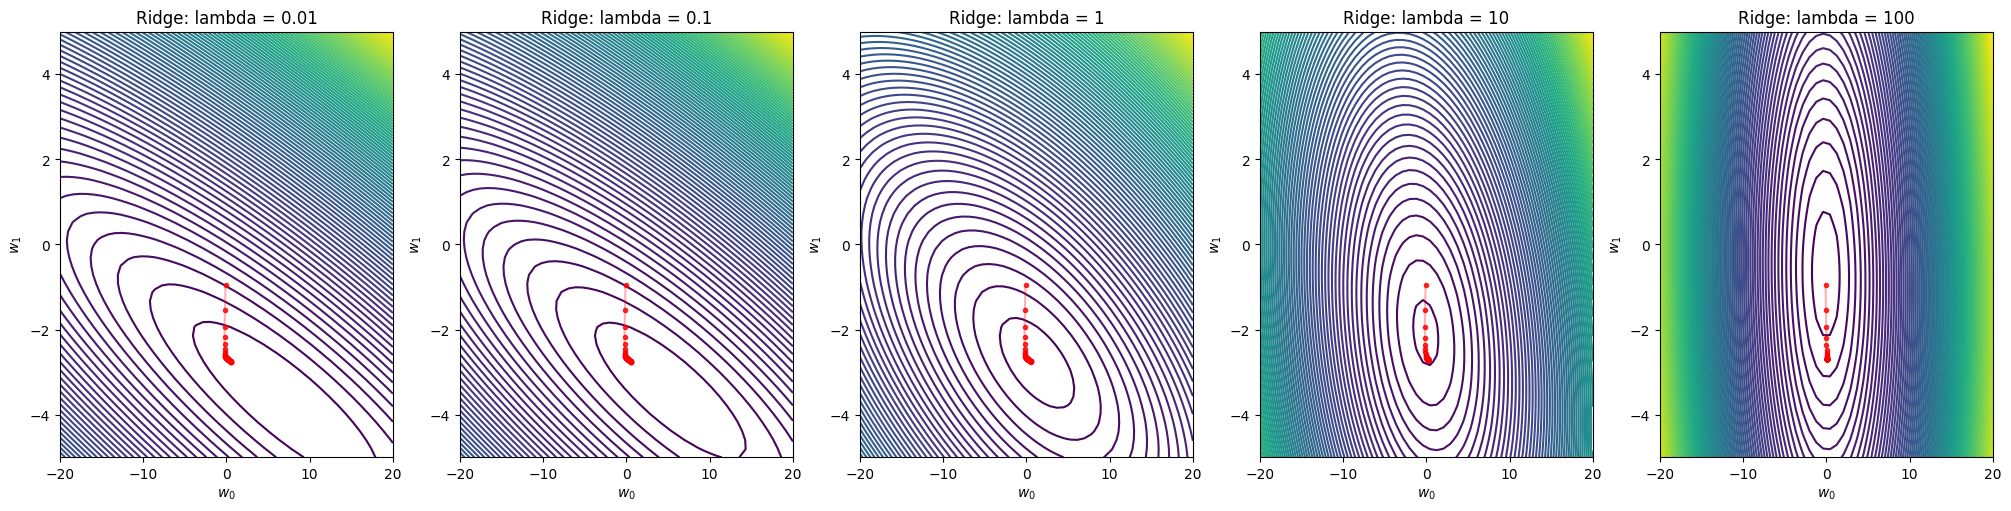

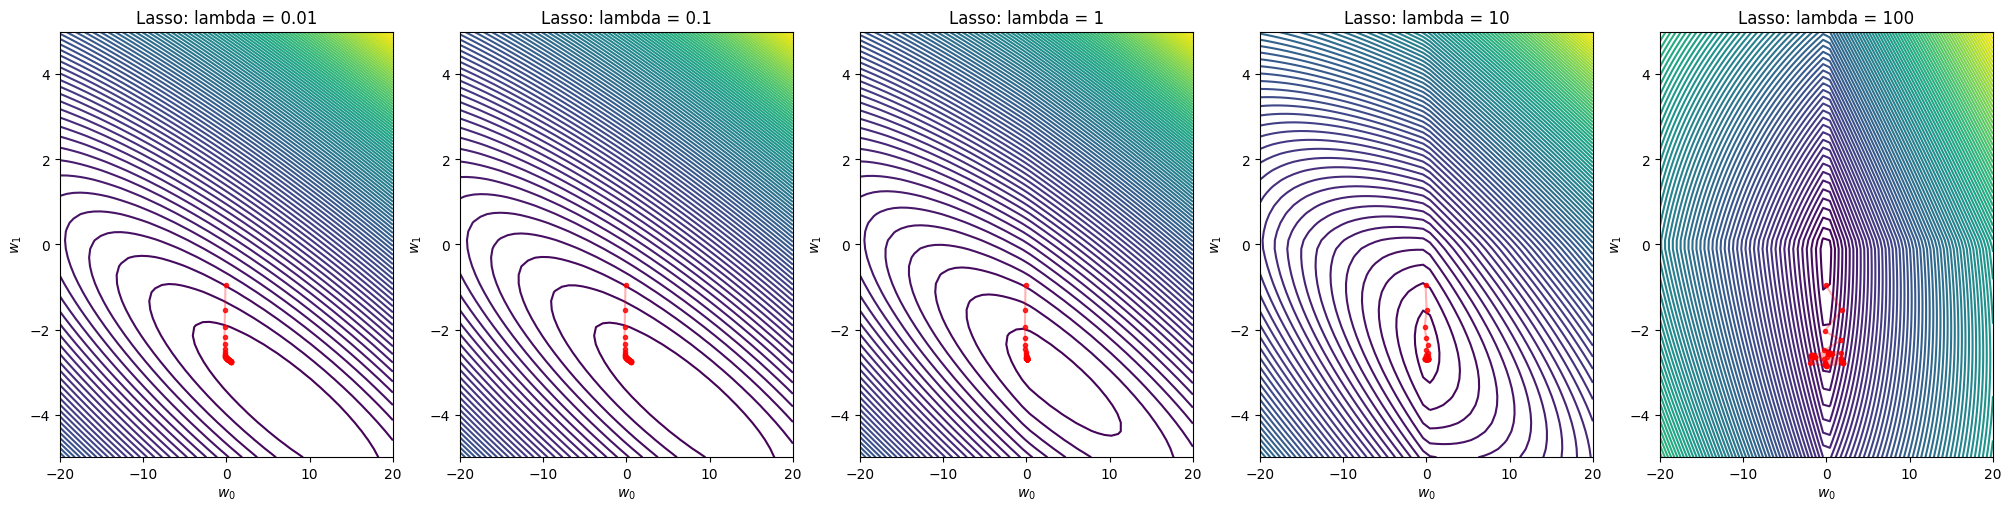

In [ ]:
# Cost function with L2 regularization
def cost_l2(w, reg):
    return .5 * np.mean((w[0] + w[1] * x - y2) ** 2) + reg * np.dot(w, w) / 2

# Cost function for L1 regularization (Lasso)
def cost_l1(w, reg):
    return .5 * np.mean((w[0] + w[1] * x - y2) ** 2) + reg * np.sum(np.abs(w))


# Generate synthetic data
N = 20
x = np.random.rand(N) * 10
y2 = -4 * x + 10 + 2 * np.random.randn(N)

# Function to plot contours
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f([xg[i, j], yg[i, j]])
    ax.contour(xg, yg, zg, 100)
    return ax

# List of regularization strengths
lambda_values = [0.01, 0.1, 1, 10, 100]

# Plotting for L2 (Ridge)
fig, axes = plt.subplots(ncols=len(lambda_values), nrows=1, constrained_layout=True, figsize=(20, 5))
for i, reg_coef in enumerate(lambda_values):
    model = LinearRegression(regularization='L2', alpha=reg_coef, learning_rate=0.01, max_iter=50, use_gradient_descent=True)
    model.fit(x, y2)

    current_cost = lambda w: cost_l2(w, reg_coef)

    plot_contour(current_cost, [-20, 20], [-5, 5], 50, axes[i])

    w_hist = np.vstack(model.w_history)
    axes[i].plot(w_hist[:, 1], w_hist[:, 0], '.r', alpha=0.8)
    axes[i].plot(w_hist[:, 1], w_hist[:, 0], '-r', alpha=0.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f'Ridge: lambda = {reg_coef}')
    axes[i].set_xlim([-20, 20])
    axes[i].set_ylim([-5, 5])

plt.show()

# Plotting for L1 (Lasso)
fig, axes = plt.subplots(ncols=len(lambda_values), nrows=1, constrained_layout=True, figsize=(20, 5))
for i, reg_coef in enumerate(lambda_values):
    model = LinearRegression(regularization='L1', alpha=reg_coef, learning_rate=0.01, max_iter=50, use_gradient_descent=True)
    model.fit(x, y2)

    current_cost = lambda w: cost_l1(w, reg_coef)

    plot_contour(current_cost, [-20, 20], [-5, 5], 50, axes[i])

    w_hist = np.vstack(model.w_history)
    axes[i].plot(w_hist[:, 1], w_hist[:, 0], '.r', alpha=0.8)
    axes[i].plot(w_hist[:, 1], w_hist[:, 0], '-r', alpha=0.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f'Lasso: lambda = {reg_coef}')
    axes[i].set_xlim([-20, 20])
    axes[i].set_ylim([-5, 5])

plt.show()